Note to self: I should defintely explore an object-oriented PyTorch approach in the future. It is annoying having to pass around every single required variable to helper functions

Attempt to approximate period Sine-Gordon Equation

Import Statements

In [13]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

Some Variables

In [14]:
#number of intermediate steps
q = 500

#step size
h = 0.8

#start and end location
start_t = 0
end_t = start_t + h

N = 100 #number of x values for training

Import Data

In [15]:
#CREDIT TO https://github.com/maziarraissi/PINNs/blob/master/appendix/discrete_time_inference%20(Burgers)/Burgers_systematic.py FOR THE BELOW CODE TO IMPORT IRK WEIGHTS AND THE LABEL DATA (AND FOR THE DATA ITSELF)

tmp = np.float32(np.loadtxt('./data/Butcher_IRK%d.txt' % (q), ndmin = 2))
IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q)) #presume the first q rows and q columns represent a_{ij} values, and the final row represents the b_j values
IRK_times = tmp[q**2+q:] #not sure what this is used for


#I may choose to generate my own data once more...
'''
data = scipy.io.loadmat('./data/burgers_shock.mat')

t_points = data['t'].flatten()[:,None] # T x 1
x_points = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

#get data labels at t = 0.9 
index = np.where(t_points == end_t)[0][0]
end_labels = Exact[index, :]'''

"\ndata = scipy.io.loadmat('./data/burgers_shock.mat')\n\nt_points = data['t'].flatten()[:,None] # T x 1\nx_points = data['x'].flatten()[:,None] # N x 1\nExact = np.real(data['usol']).T # T x N\n\n#get data labels at t = 0.9 \nindex = np.where(t_points == end_t)[0][0]\nend_labels = Exact[index, :]"

Generate Data

In [16]:
#input = np.random.rand(N) * 2 * np.pi - np.pi #x values between -pi and pi
input = np.linspace(-np.pi, np.pi, num=100, endpoint=True)

sigma = 1

initial_vals =  4*np.arctan(np.exp( -(input**2)/(2*(sigma**2)) )) #initial values at t = 0. u(0, x) = 4arctan(exp(-\frac{x^2}{2sigma^2}))

Define Network

In [17]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_func = nn.Tanh()
        self.predict = nn.Sequential(
            nn.Linear(1, 50),
            self.act_func,
            nn.Linear(50, 50),
            self.act_func,
            nn.Linear(50, 50),
            self.act_func,
            nn.Linear(50, q + 1)
        )

    def forward(self, x):
        x = self.predict(x)
        return x

Helper Methods

In [18]:
'''#Nonelinear Burgers' Operator
def NLO(input, outputs, device): #outputs is of the form N x q. Inputs is of form N x 1 and was used to get outputs


    u = outputs
    print(input.shape)
    print(u.shape)

    u_x = jacobian(lambda u,x: u, (u, input), create_graph=True, vectorize=True)

    print(len(u_x))
    print(u_x[0].shape)
    print(u_x[1].shape)

    u_x = u_x.squeeze(-1) #Jacobian with vectorize should return shape (N, q, 1)

    u_xx = jacobian(lambda u_x, x: u_x, (u_x, input), create_graph=True, vectorize=True)

    u_xx = u_xx.squeeze(-1)


    return u * u_x - (0.01/torch.pi)*u_xx'''

"#Nonelinear Burgers' Operator\ndef NLO(input, outputs, device): #outputs is of the form N x q. Inputs is of form N x 1 and was used to get outputs\n\n\n    u = outputs\n    print(input.shape)\n    print(u.shape)\n\n    u_x = jacobian(lambda u,x: u, (u, input), create_graph=True, vectorize=True)\n\n    print(len(u_x))\n    print(u_x[0].shape)\n    print(u_x[1].shape)\n\n    u_x = u_x.squeeze(-1) #Jacobian with vectorize should return shape (N, q, 1)\n\n    u_xx = jacobian(lambda u_x, x: u_x, (u_x, input), create_graph=True, vectorize=True)\n\n    u_xx = u_xx.squeeze(-1)\n\n\n    return u * u_x - (0.01/torch.pi)*u_xx"

In [19]:
'''
'''

#Nonelinear Burgers' Operator
def NLO(input, outputs, device): #outputs is of the form N x q. Inputs is of form N x 1 and was used to get outputs


    global N
    global q

    final_output = torch.empty(N, q, requires_grad=True).to(device)

    u = outputs.to(torch.float32)

    for i in range(q):

        new_u = u[:, i].view(-1, 1).to(torch.float32)

        u_x = torch.autograd.grad(new_u, input, grad_outputs=torch.ones_like(new_u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, input, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        #print(new_u.shape)
        #print(u_x.shape)
        #print(u_xx.shape)
        #print(final_output[:, i].shape)
        new_column = (-u_xx + torch.sin(new_u)).squeeze(-1).to(device)
        final_output = torch.cat([final_output[:, :i], new_column.unsqueeze(1), final_output[:, i+1:]], dim=1).to(device)



    return final_output



    #return outputs

    
    


#Implicit Runge-Kutta Calculation (Combine Intermediate Terms with Butcher Tableau Coefficients)
def IRK(input, outputs, initial_vals, coefficients, device): #outputs is tensor of size Nx(q+1), represnting q stages for N x-values and the final n+1 prediction. coefficients is a tensor of size (q+1) x q representing the Butcher Tableau. Input and initial_vals are size (N)

    outputs_truncated = outputs[:, :-1] #get all but last row

    global N
    global q
    global h


    NLO_outputs = NLO(input, outputs_truncated, device) #perform non-linear operation on each of the outputs_truncated. Shape is still (N, q)
    
    N_coefficients = coefficients.repeat(N, 1, 1) #stack N coefficients tensors on top of each other
    NLO_outputs = NLO_outputs.unsqueeze(-1) #reshape NLO_outputs_reshaped into shape (N, q, 1) for matrix multiplication

    coefficients_applied = torch.bmm(N_coefficients, NLO_outputs) #perform matrix multiplication. This represents applying the coefficients a_{ij} (and b_i for n+1 prediction) from the Butcher Tableau to every element in NLO_outputs and THEN recombining them to make every new value which will go on to form the "calculated" outputs (intermediate stage values). Has shape (N, q+1, 1), since N_coefficients has shape (N, q+1, q) and NLO_outputs has shape (N, q, 1). For each layer in N, the matrix mulitplcaion (q+1, q) x (q, 1) takes place, resulting in a vector of shape (q+1, 1). N of these makes (N, q+1, 1)
    coefficients_applied = coefficients_applied.view(N, -1) #now shape (N, q + 1)

    coefficients_applied = -h * coefficients_applied #apply the -h (-\delta t) to each element in coefficients_applied
    initial_vals = initial_vals.view(-1, 1) #reshape initial_vals from (N) to (N, 1)

    result = coefficients_applied + initial_vals #Every element in coefficients_applied has a value added to it which is the element from initial_vals on the same layer. We can add the shapes (N, q+1) and (N, 1) due to "broadcasting", which effectively stretches the shape of the vector

    return result #returns a result which is the same shape as "outputs" and represents the same intermediate values, except these are the "calculated" versions and not the "direct predictions"


    

Loss Functions

In [20]:
'''

'''

def SSE_n(input, outputs, initial_vals, coefficients, device):

    calculated_outputs = IRK(input, outputs, initial_vals, coefficients, device)

    SSE_n_loss = torch.sum((calculated_outputs - outputs)**2)

    return SSE_n_loss


def SSE_b(network, outputs, device):
    
    half_N_round_down = N // 2

    first_half_outputs = outputs[:half_N_round_down]
    second_half_outputs = outputs[-half_N_round_down:]
    second_half_outputs = torch.flip(second_half_outputs, dims=[0]) #reverse the direction across dim 0

    difference = first_half_outputs - second_half_outputs

    return torch.sum(difference**2)



def SSE(input, outputs, initial_vals, coefficients, network, device):
    SSE_n_loss = SSE_n(input, outputs, initial_vals, coefficients, device)
    SSE_b_loss = SSE_b(network, outputs, device)
    return SSE_n_loss + SSE_b_loss, SSE_n_loss, SSE_b_loss

Training Setup

In [21]:
pinn = PINN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
pinn.to(device)


input = torch.tensor(input.astype(np.float32), requires_grad=True).to(device).view(-1, 1)
initial_vals = torch.tensor(initial_vals.astype(np.float32)).to(device).view(-1, 1)
coefficients = torch.tensor(IRK_weights.astype(np.float32)).to(device)

i = 0

Using device: CPU


Optimizer

In [22]:
optimizer = torch.optim.LBFGS(pinn.parameters(), #PARAMETERS CREDIT TO https://github.com/teeratornk/PINNs-2/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb
                              lr=1.0,
                              max_iter=50000, 
                                max_eval=50000, 
                                history_size=50,
                                tolerance_grad=1e-5, 
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe"
                              )

Training

In [23]:
def closure():
    optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
    outputs = pinn(input) #run the batch through the current model
    
    overall_loss, SSE_n, SSE_b = SSE(input, outputs, initial_vals, coefficients, pinn, device) #calculate the loss
    overall_loss.backward() #Using backpropagation, calculate the gradients
    #print(f"Avg loss: {loss.item()}")

    global i
    #if i%100 == 0:
    print(f"STEP: {i} | Avg Losses | SSE_n: {SSE_n.item()} | SSE_b: {SSE_b.item()} | Total: {overall_loss.item()}")
    i += 1

    return overall_loss

optimizer.step(closure) #Using the gradients, adjust the parameters   

STEP: 0 | Avg Losses | SSE_n: 158895.0625 | SSE_b: 721.5097045898438 | Total: 159616.578125
STEP: 1 | Avg Losses | SSE_n: 158716.9375 | SSE_b: 710.3372192382812 | Total: 159427.28125
STEP: 2 | Avg Losses | SSE_n: 157917.0625 | SSE_b: 661.29541015625 | Total: 158578.359375
STEP: 3 | Avg Losses | SSE_n: 149584.0 | SSE_b: 266.8204345703125 | Total: 149850.828125
STEP: 4 | Avg Losses | SSE_n: 86685.0 | SSE_b: 515.3359375 | Total: 87200.3359375
STEP: 5 | Avg Losses | SSE_n: 101697.359375 | SSE_b: 3393.7265625 | Total: 105091.0859375
STEP: 6 | Avg Losses | SSE_n: 60006.25390625 | SSE_b: 776.4449462890625 | Total: 60782.69921875
STEP: 7 | Avg Losses | SSE_n: 39605.06640625 | SSE_b: 3465.960205078125 | Total: 43071.02734375
STEP: 8 | Avg Losses | SSE_n: 114293.5625 | SSE_b: 6864.41845703125 | Total: 121157.984375
STEP: 9 | Avg Losses | SSE_n: 29327.08203125 | SSE_b: 5027.220703125 | Total: 34354.3046875
STEP: 10 | Avg Losses | SSE_n: 25294.1171875 | SSE_b: 2656.96630859375 | Total: 27951.08398

KeyboardInterrupt: 

Evaluation

Graphing

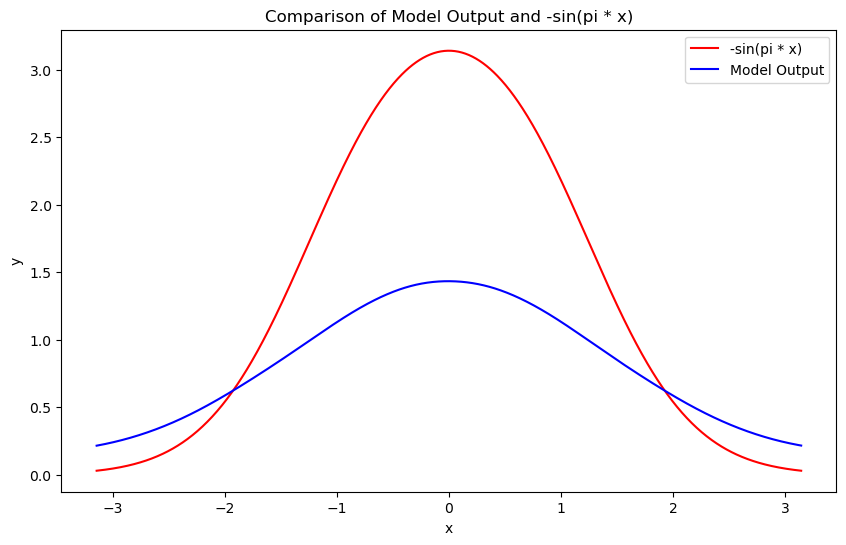

In [24]:
num_points = 1000

# Generate x values
x_vals = torch.linspace(-np.pi, np.pi, num_points).view(-1, 1).to(device)

# Run the model to get predictions
with torch.no_grad():
    model_output = pinn(x_vals)

# Take the q+1th output of the model (last output)
final_output = model_output[:, -1].cpu().numpy()

# Generate the original function values
y_vals = 4*np.arctan(np.exp( -(x_vals.cpu().numpy()**2)/(2*(sigma**2)) ))


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals.cpu().numpy(), y_vals, 'r', label='-sin(pi * x)')
plt.plot(x_vals.cpu().numpy(), final_output, 'b', label='Model Output')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Output and -sin(pi * x)')
plt.show()


Saving

In [ ]:
toSave = True

if toSave:
    base_path = "./"
    base_name = "irk_pinn_sine_gordon_periodic"
    extension = ".pth"

    counter = 0
    model_save_path = os.path.join(base_path, base_name + extension)

    while os.path.exists(model_save_path):
        counter += 1
        model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

    torch.save(pinn.state_dict(), model_save_path)

    print("Model saved!")

Model saved!
